In [1]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 58.85%
F1 Scores: [0.72072072 0.55670103 0.52380952 0.52173913]


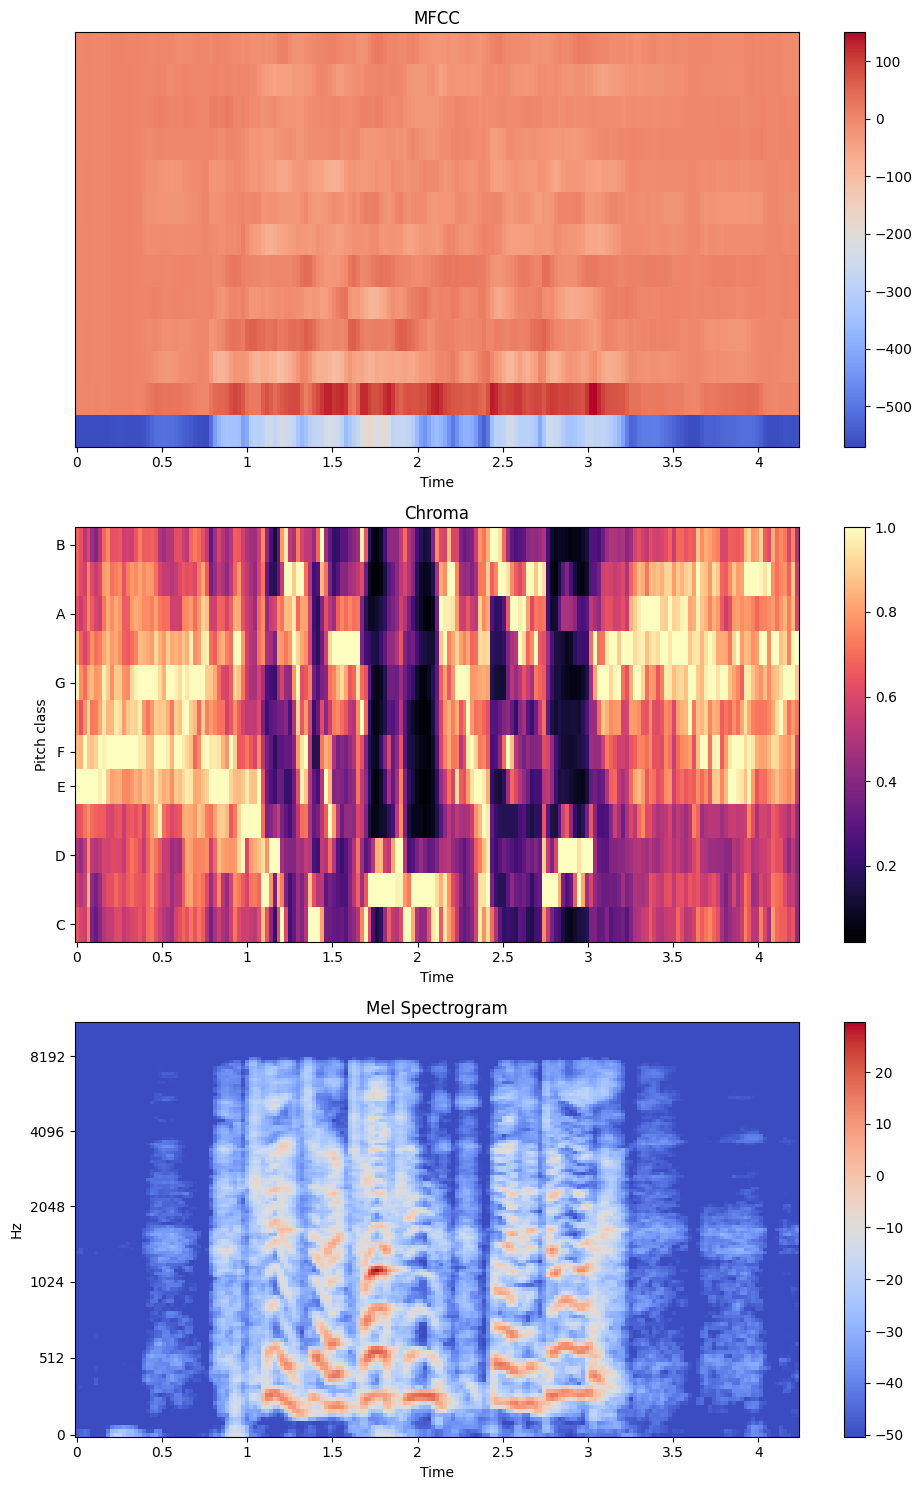

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8311d16bf25de9778e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


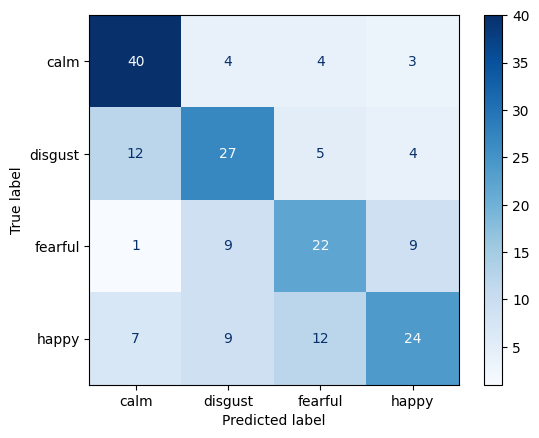

In [2]:
import os
from google.colab import drive
import librosa
import soundfile
import glob
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import gradio as gr
import pickle

# Set up the working directory and mount Google Drive
Root = "/content/drive/MyDrive/Colab Notebooks/RAVDESS_Emotional_speech_audio"
os.chdir(Root)
drive.mount('/content/drive')

# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Emotions to observe
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    X, sample_rate = librosa.load(file_name, sr=None)
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    if chroma:
        stft = np.abs(librosa.stft(X))
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_features))

    if mel:
        mel_features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_features))

    return result

# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/RAVDESS_Emotional_speech_audio/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

# Initialize the Support Vector Classifier
model = SVC(kernel='linear', probability=True)

# Train the model and track training accuracy over "epochs"
epochs = 10  # Simulated epochs for demonstration purposes
for epoch in range(epochs):
    model.fit(x_train, y_train)

# Predict for the test set
y_pred = model.predict(x_test)

# Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate F1 score
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 Scores:", f1_scores)

# Save the model to a file
with open('modelForPrediction1.sav', 'wb') as f:
    pickle.dump(model, f)

# Function to visualize MFCCs, Chroma features and Mel spectrograms of an audio file
def visualize_features(file_name):
    X, sample_rate = librosa.load(file_name)

    # Create subplots for MFCCs and Chroma features
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))

    # MFCCs
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    img1 = librosa.display.specshow(mfccs, x_axis='time', ax=ax[0])
    ax[0].set(title='MFCC')
    fig.colorbar(img1, ax=ax[0])

    # Chroma features
    stft = np.abs(librosa.stft(X))
    chroma_features = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    img2 = librosa.display.specshow(chroma_features, y_axis='chroma', x_axis='time', ax=ax[1])
    ax[1].set(title='Chroma')
    fig.colorbar(img2, ax=ax[1])

    # Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    img3 = librosa.display.specshow(librosa.power_to_db(mel_spectrogram), y_axis='mel', x_axis='time', ax=ax[2])
    ax[2].set(title='Mel Spectrogram')
    fig.colorbar(img3, ax=ax[2])

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)

    disp.plot(cmap=plt.cm.Blues)

# Visualize features for a specific audio file (example usage)
audio_file_path = '/content/drive/MyDrive/Colab Notebooks/RAVDESS_Emotional_speech_audio/speech-emotion-recognition-ravdess-data/Actor_01/03-01-06-02-01-02-01.wav'
visualize_features(audio_file_path)

# Plot confusion matrix for predictions
plot_confusion_matrix(y_test, y_pred)

# Function to predict emotion from an audio file for Gradio interface
def predict_emotion(audio_file):
    feature = extract_feature(audio_file)
    feature = feature.reshape(1,-1)
    prediction = model.predict(feature)
    return prediction[0]

# Create Gradio interface for prediction
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="filepath"),  # Updated line without 'source'
    outputs="text",
    title="Speech Emotion Recognition",
    description="Upload an audio file to recognize the emotion."
)

# Launch the Gradio interface
iface.launch()